In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import matplotlib as mpl
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-23T16:59:22.212781+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1031-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.10.0
seaborn   : 0.13.2
teeplot   : 1.4.2
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-01-cpp-bench-memory-native-tilted"
)
teeplot_subdir


'2025-06-01-cpp-bench-memory-native-tilted'

## Prep Data


In [5]:
algo_names = {
    "dstream_tilted_algo": "dstream tilted",
    "doubling_tilted_algo": "doubling tilted",
    "zhao_tilted_algo": "zhao tilted",
    "zhao_tilted_full_algo": "zhao tilted full",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/r9ajf/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
        pl.col("num_items") == 1_000_000,
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        ),
        num_retained=(
            pl.when(pl.col("algo_name") == "dstream_tilted_algo")
            .then(pl.col("num_sites"))
            .when(pl.col("algo_name") == "doubling_tilted_algo")
            .then(pl.col("num_sites") * 0.75)
            .when(pl.col("algo_name") == "zhao_tilted_algo")
            .then(19)
            .when(pl.col("algo_name") == "zhao_tilted_full_algo")
            .then(pl.col("num_sites"))
            .otherwise(None)
        )
    )
    .with_columns(
        (pl.col("memory_bytes") / pl.col("num_retained")).alias("bytes per item"),
    )
    .with_columns(
        (8 * pl.col("memory_bytes") / pl.col("num_retained")).alias("bits per item"),
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,str
"""count""","""640""","""640""","""640""",640.0,640.0,640.0,640.0,640.0,"""640""",640.0,640.0,640.0,"""640"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,1873.125,1e6,1360.0,4.5,0.035218,null,939.75,2.981575,23.852599,null
"""std""",null,null,null,3783.216488,0.0,1621.22263,2.874528,0.183325,null,1409.300362,2.142299,17.138394,null
"""min""","""doubling_tilted_algo""","""bit""","""g++""",12.0,1e6,64.0,0.0,0.001376,"""doubling tilted""",19.0,0.125977,1.0078125,"""bit"""
"""25%""",null,null,null,105.0,1e6,256.0,2.0,0.0039,null,48.0,1.125,9.0,null
"""50%""",null,null,null,260.0,1e6,1024.0,5.0,0.005605,null,256.0,2.671875,21.375,null
"""75%""",null,null,null,1152.0,1e6,1024.0,7.0,0.009873,null,1024.0,4.526316,36.210526,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,9.0,1.485777,"""zhao tilted full""",4096.0,7.526316,60.210526,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,str
"""dstream_tilted_algo""","""double word""","""g++""",16388,1000000,4096,0,0.005704,"""dstream tilted""",4096.0,4.000977,32.007812,"""double word"""
"""dstream_tilted_algo""","""double word""","""g++""",16388,1000000,4096,1,0.005799,"""dstream tilted""",4096.0,4.000977,32.007812,"""double word"""
"""dstream_tilted_algo""","""double word""","""g++""",16388,1000000,4096,2,0.005685,"""dstream tilted""",4096.0,4.000977,32.007812,"""double word"""
"""dstream_tilted_algo""","""double word""","""g++""",16388,1000000,4096,3,0.005718,"""dstream tilted""",4096.0,4.000977,32.007812,"""double word"""
"""dstream_tilted_algo""","""double word""","""g++""",16388,1000000,4096,4,0.005803,"""dstream tilted""",4096.0,4.000977,32.007812,"""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,0.012034,"""zhao tilted full""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,0.011279,"""zhao tilted full""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,0.011607,"""zhao tilted full""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,0.011094,"""zhao tilted full""",64.0,1.125,9.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,0.011309,"""zhao tilted full""",64.0,1.125,9.0,"""bit"""


In [6]:
assert (df.group_by(
    ["num_items", "num_sites", "algorithm", "data type"],
).agg(
    pl.col("memory_bytes").n_unique(),
)["memory_bytes"] == 1).all()


## Plot


## Memory Use


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


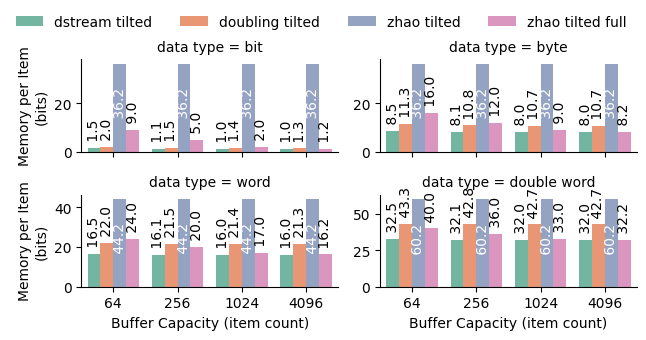

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


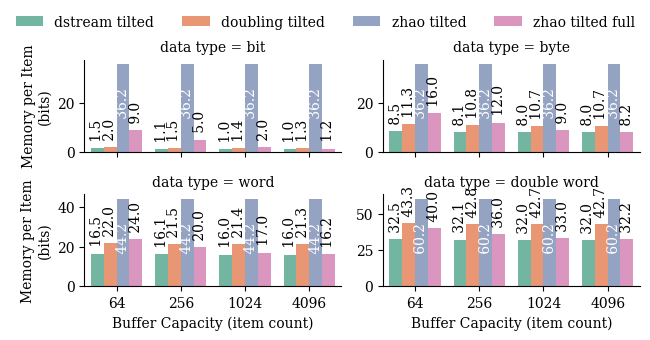

In [7]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y="bits per item",
            hue="algorithm",
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette="Set2",
            sharey=False,
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels("Memory per Item\n(bits)")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                ncol=4,
                frameon=False,
                title=None,
            )
            for row, ax in enumerate(g.axes.flat):
                ax.bar_label(
                    ax.containers[0],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )
                ax.bar_label(
                    ax.containers[1],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )
                ax.bar_label(
                    ax.containers[2],
                    fmt=" %.1f",
                    label_type="center",
                    rotation=90,
                    padding=2,
                    color="white",
                )
                ax.bar_label(
                    ax.containers[3],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


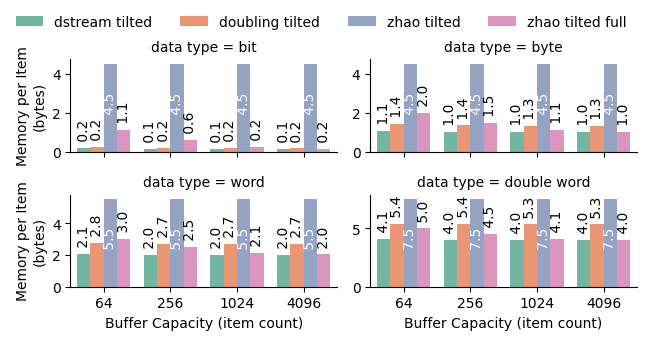

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-01-cpp-bench-memory-native-tilted/col=data-type+hue=algorithm+kind=bar+palette=set2+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


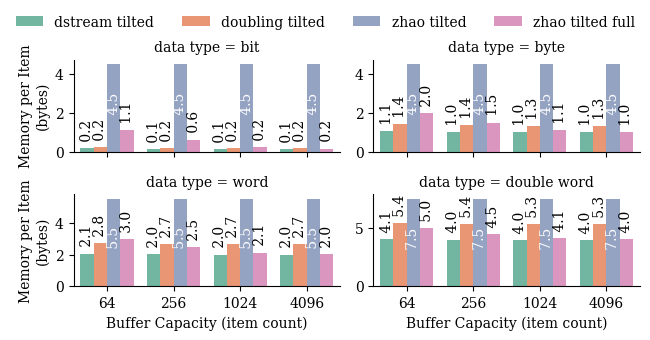

In [8]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y="bytes per item",
            hue="algorithm",
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette="Set2",
            sharey=False,
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels("Memory per Item\n(bytes)")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                ncol=4,
                frameon=False,
                title=None,
            )
            for row, ax in enumerate(g.axes.flat):
                ax.bar_label(
                    ax.containers[0],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )
                ax.bar_label(
                    ax.containers[1],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )
                ax.bar_label(
                    ax.containers[2],
                    fmt=" %.1f",
                    label_type="center",
                    rotation=90,
                    padding=2,
                    color="white",
                )
                ax.bar_label(
                    ax.containers[3],
                    fmt=" %.1f",
                    label_type="edge",
                    rotation=90,
                    padding=2,
                )
